In [28]:
#Necessary Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [2]:
#Load in data for New York
nyc_data = pd.read_csv('NYC_Property_Sales_Apartments.csv')
nyc_data = nyc_data[['borough', 'neighborhood', 'gross_square_feet', 'sale_price']]
nyc_data['city'] = 'New York'
nyc_data['borough'] = nyc_data['borough'].str.lower()
nyc_data['neighborhood'] = nyc_data['neighborhood'].str.lower()
nyc_data['city'] = nyc_data['city'].str.lower()

#Load in data for London
london_data = pd.read_csv('London.csv')
london_data = london_data.rename(columns={
    'City/County': 'city',
    'Location': 'neighborhood',
    'Area in sq ft': 'gross_square_feet',
    'Price': 'sale_price'
})
london_data['sale_price'] *= 1.24  # adjust the sale price to match USD
london_data['borough'] = ''  # since london does not have boroughs we do not need it
london_data['city'] = london_data['city'].str.lower()
london_data['neighborhood'] = london_data['neighborhood'].str.lower()

london_data = london_data[['city', 'borough', 'neighborhood', 'gross_square_feet', 'sale_price']]

'''
Renamed all of the the columns in the london dataset as well as added a borough column in order to make sure it aligns with the columns that we used for the new york dataset in order
for them to be combined and to easily be able to train on both the data sets so that we could use them for evaluation and user input as well. 
'''

# combine the two data sets 
data = pd.concat([nyc_data, london_data], ignore_index=True)

# multiple different cities
multiple_cities = pd.read_csv('multiple cities.csv')

multiple_cities.rename(columns={
    'Metro': 'city',            
    'city': 'neighborhood',     
    'sq ft': 'gross_square_feet', 
    'price': 'sale_price'     
}, inplace=True)

multiple_cities['city'] = multiple_cities['city'].str.lower()
multiple_cities['neighborhood'] = multiple_cities['neighborhood'].str.lower()

data = pd.concat([data, multiple_cities], ignore_index=True)

data['gross_square_feet'] = pd.to_numeric(data['gross_square_feet'], errors='coerce')
data['sale_price'] = pd.to_numeric(data['sale_price'], errors='coerce')

In [20]:
#preprocessing, filter out potential outliers
filtered_data = data[
    (data['gross_square_feet'] > 100) & (data['gross_square_feet'] < 20000) &
    (data['sale_price'] > 50000) & (data['sale_price'] < 10000000)
]

features = filtered_data[['city', 'borough', 'neighborhood', 'gross_square_feet']]
target = filtered_data['sale_price']

column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['city', 'borough', 'neighborhood'])
], remainder='passthrough')

#features_encoded = column_transformer.fit_transform(features)
features_encoded = features.copy()
features_encoded['city'] = features_encoded['city'].factorize()[0]
features_encoded['borough'] = features_encoded['borough'].fillna('')
features_encoded['borough'] = features_encoded['borough'].factorize()[0]
features_encoded['neighborhood'] = features_encoded['neighborhood'].factorize()[0]

In [22]:
features_encoded

,city,borough,neighborhood,gross_square_feet
0,0,0,0,1470.0
1,0,0,0,1497.0
2,0,0,0,1296.0
3,0,0,0,2047.0
4,0,0,0,1560.0
...,...,...,...,...
44153,62,5,893,496.0
44172,62,5,893,818.0
44173,62,5,893,148.0
44207,62,5,893,997.0


In [23]:
# split data sets for training and testing
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# create our model and fit/train it
model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=20,
                      n_estimators=1000, random_state=42)

In [24]:
X_train.shape

(32018, 4)

In [25]:
y_pred = model.predict(X_test)

# evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R^2: {r2:.2f}")

Random Forest RMSE: 698718.48
Random Forest R^2: 0.72


In [ ]:
#allow user input

def predict_property_price(city, borough, neighborhood, square_feet):
    input_data = {
        'city': [city.lower()],
        'borough': [borough.lower()],
        'neighborhood': [neighborhood.lower()],
        'gross_square_feet': [square_feet]
    }

    input_df = pd.DataFrame(input_data)

    transformed_input = column_transformer.transform(input_df)

    predicted_price = model.predict(transformed_input)

    return f"Sale price prediction for the property: ${predicted_price[0]:,.2f}"

# change here for user input it is not case sensitive, leave borough blank unless you are doing new york as your city and doing a neighborhood in NYC
print(predict_property_price('chicago', '', 'chicago', 800))
print(predict_property_price('new york', '', 'astoria', 3000))


[0.04517255 0.14680425 0.27711845 0.53090475]


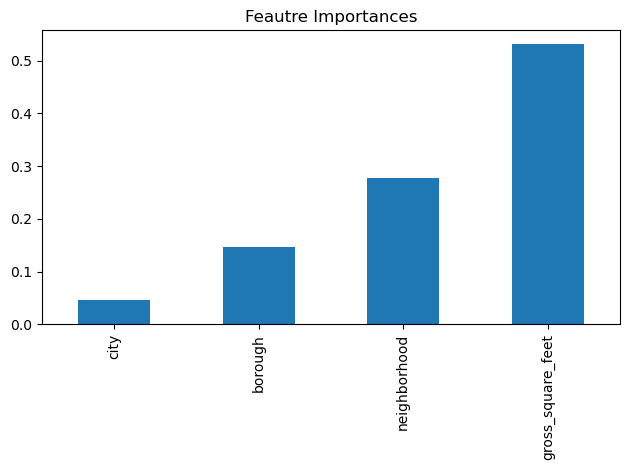

In [30]:
important =  model.feature_importances_
print(important)
#print("Feature importance:", important)
feature_names = ['city', 'borough', 'neighborhood', 'gross_square_feet']
forest_importances = pd.Series(important, index = feature_names)

fig,ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feautre Importances")
fig.tight_layout()

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

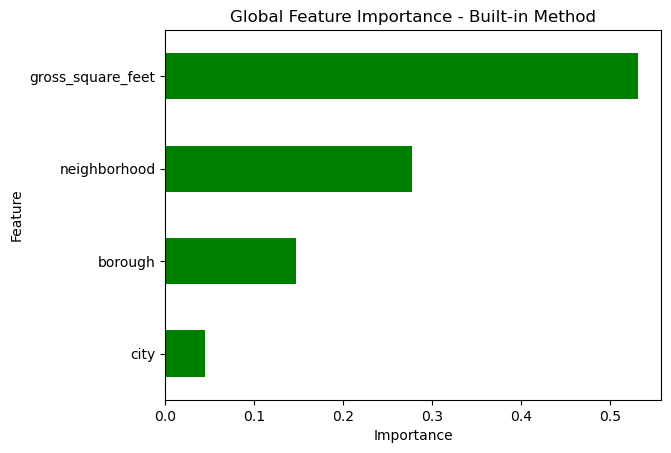

In [31]:
cols = ['city', 'borough', 'neighborhood', 'gross_square_feet']
global_importances = pd.Series(model.feature_importances_, index=cols)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")